Import modules and dataset



In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn import discriminant_analysis as da
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, accuracy_score

from scipy.special import expit
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Global YouTube Statistics.csv'
df = pd.read_csv(path, encoding='latin1')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,245000000,2.280000e+11,Music,T-Series,20082,India,IN,Music,...,2000000.0,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,YouTube Movies,170000000,0.000000e+00,Film & Animation,youtubemovies,1,United States,US,Games,...,NaN,2006.0,Mar,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,MrBeast,166000000,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,Natan por Aï¿,12300000,9.029610e+09,Sports,Natan por Aï¿,1200,Brazil,BR,Entertainment,...,700000.0,2017.0,Feb,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280
991,992,Free Fire India Official,12300000,1.674410e+09,People & Blogs,Free Fire India Official,1500,India,IN,Games,...,300000.0,2018.0,Sep,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
992,993,Panda,12300000,2.214684e+09,NaN,HybridPanda,2452,United Kingdom,GB,Games,...,1000.0,2006.0,Sep,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973
993,994,RobTopGames,12300000,3.741235e+08,Gaming,RobTopGames,39,Sweden,SE,Games,...,100000.0,2012.0,May,9.0,67.0,1.028545e+07,6.48,9021165.0,60.128161,18.643501


The Following Section contains the Module 1 code because Module 2 will not run properly without it.

In [ ]:
df['video views'] = df['video views'].replace(0, np.nan)
df = df.dropna(subset=['video views'])

df['subscribers'] = df['subscribers'].replace(0, np.nan)
df = df.dropna(subset=['subscribers'])

# Lower bound uploads is a requirement we have made for a channel to demonstrate that they are not one-hit wonders and have dedicated time to being a YouTuber.
lower_bound_uploads = 50

df = df[df['uploads'] >= lower_bound_uploads]

# Channels of the music type are channels such as VEVO and other labels.
# We do not consider these channels as YouTubers as they only upload music videos of artists signed to them.
df = df[df['channel_type'] != 'Music']

df['log_uploads'] = np.log1p(df['uploads'])
df['log_video_views'] = np.log1p(df['video views'])
df['log_subscribers'] = np.log1p(df['subscribers'])

q1 = df['log_video_views'].quantile(0.25)
q3 = df['log_video_views'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df.loc[(df['log_video_views'] >= lower_bound) & (df['log_video_views'] <= upper_bound)]


<ipython-input-41-54b8dd674ce7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subscribers'] = df['subscribers'].replace(0, np.nan)


In [ ]:
q1s = df['log_subscribers'].quantile(0.25)
q3s = df['log_subscribers'].quantile(0.75)
iqrs = q3s - q1s

lower_bounds = q1s - 1.5 * iqrs
upper_bounds = q3s + 1.5 * iqrs

df = df.loc[(df['log_subscribers'] >= lower_bounds) & (df['log_subscribers'] <= upper_bounds)]

Module 2: Data Exploration

In [ ]:
# Descriptive Statistics
df_stats = df[['log_subscribers', 'log_uploads', 'log_video_views']].describe()
print(df_stats)

# Key Points
# Uploads has a high standard deviation, showing how we did not remove outliers from it compared to video views and subscribers.
# Ranges: Upload has a large range (~8.7) compared to video views (~4.15) and subscribers (~1.17).
# This demonstrates the effectiveness of the log transformation.
# The compactness of the middle percentiles shows how we have created a normal distribution.

       log_subscribers  log_uploads  log_video_views
count       633.000000   633.000000       633.000000
mean         16.708724     7.340574        22.567860
std           0.303200     1.728664         0.771051
min          16.325110     3.931826        20.569795
25%          16.468753     6.236370        22.065584
50%          16.624913     7.081709        22.635244
75%          16.897421     8.220672        23.085412
max          17.536373    12.615892        24.736036


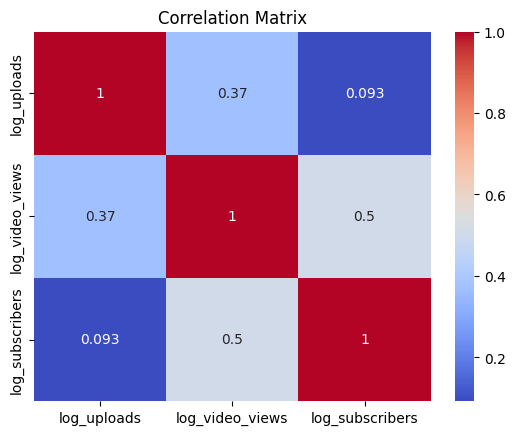

In [ ]:
# Correlation Matrix
sns.heatmap(df[['log_uploads', 'log_video_views', 'log_subscribers']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# This matrix provides coefficents ranging from 0 to 1 that shows the strength of relationship between two quantitative variables.
# From our matrix, we can see that subscribers and uploads has a very weak and positive relationship.
# Video views and uploads has a moderately weak and positive relationship.
# Interestingly, video views and subscribers has a moderate, positive relationship.

# Some conclusions we can draw from this are:
# A channel's upload count does not have a significant impact on its views count and even more so its subscribers.
# Instead, the strongest relationship from the three is a channel's views and subscribers.


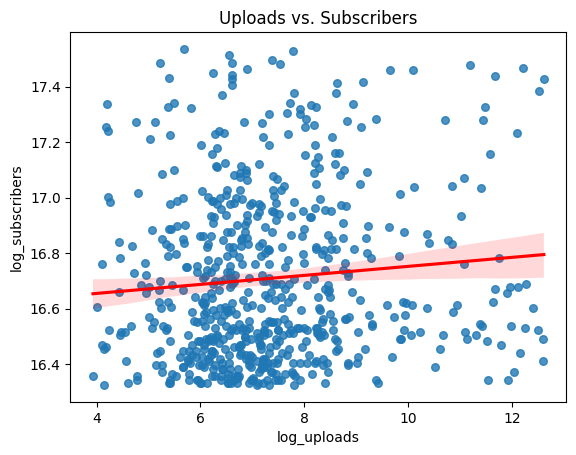

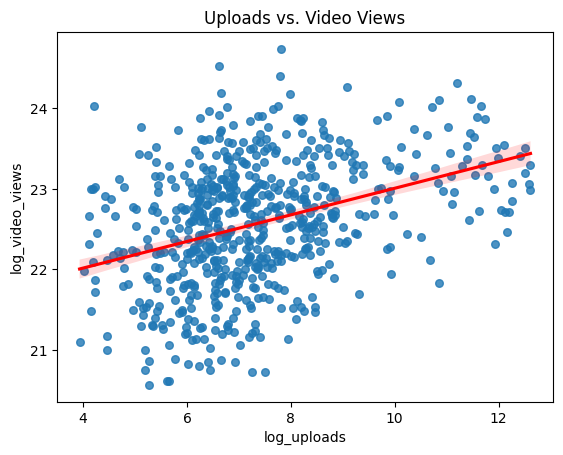

In [ ]:
# Supporting scatter plots with linear regression line
sns.regplot(x='log_uploads', y='log_subscribers', data=df, scatter_kws={'s': 30}, line_kws={'color': 'red'})

plt.title("Uploads vs. Subscribers")
plt.show()

sns.regplot(x='log_uploads', y='log_video_views', data=df, scatter_kws={'s': 30}, line_kws={'color': 'red'})

plt.title("Uploads vs. Video Views")
plt.show()

# Conclusions:
# The slope of the regression line in uploads vs subscribers is very small, nearly 0.
# This shows a weak relationship between the two variables.
# The confidence interval of the line also demonstrates how weak the relationship is
# due to the high variability of subscribers compared to uploads.
# The slope of the regression line in uploads vs video views is not strong but noticeably positive, around 0.3.
# This shows a moderately weak relationship between the two variables.
# The confidence interval of the line also demonstrates how weak the relationship is
# due to the moderately high variability of video views compared to uploads.
# The difference in strength is noticeable in the difference of compactness between both confidence intervals.

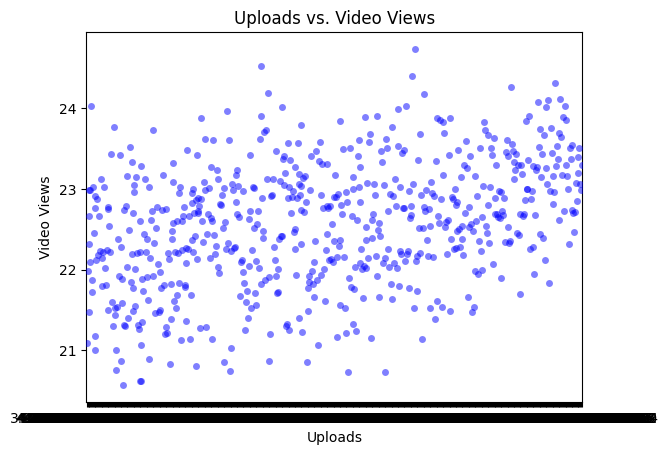

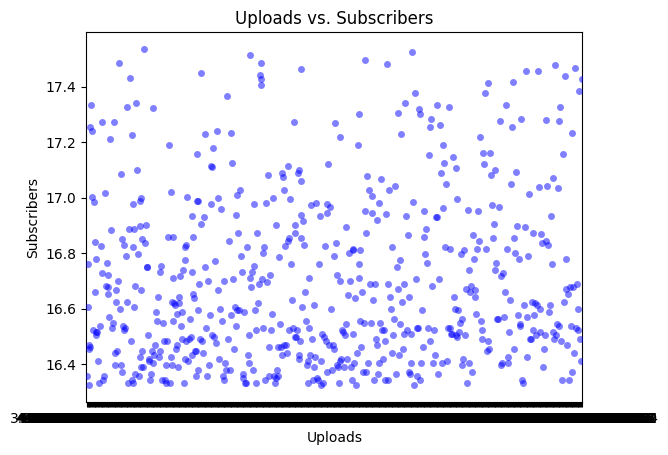

In [ ]:
# Bee Swarm Graph
sp = sns.stripplot(x='log_uploads', y='log_video_views', data=df, color='blue', alpha=0.5)
plt.title("Uploads vs. Video Views")
plt.xlabel("Uploads")
plt.ylabel("Video Views")
plt.show()

sp2 = sns.stripplot(x='log_uploads', y='log_subscribers', data=df, color='blue', alpha=0.5)
plt.title("Uploads vs. Subscribers")
plt.xlabel("Uploads")
plt.ylabel("Subscribers")
plt.show()

# Conclusions:
# Uploads vs Views
# Weak compactness but apparent.
# Trend where as uploads go up, views go up.
# Not a strong trend but noticeable.
# Uploads vs Subscribers
# No compactness noticeable
# No trend is noticeable showing the weak relationship between the two variables.
# The higher density of dots at the bottom of the graph shows how most channels
# lie in the lower half of subscribers.
